In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import time

# 데이터셋 로딩을 위한 추가 import
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

In [2]:
EPOCH = 15
MILESTONE = [4, 8, 12]
BATCH = 32  # 128에서 32로 감소 (GPU 메모리 절약)
LR=0.05

**파일 설명**
- Cifar-10의 데이터 크기가 모델에 비해 너무 간단하여 가설과 전혀 다른 결과가 나옴
- 따라서 kaggle에서 다운 받은 dogs vs cats 데이터로 2차 실험 진행
- 근데... BATCH 128로 실험하니까 자꾸 노트북이 꺼져요 ㅠㅠ 
- 결국 BATCH 64로 진행... 또 꺼져요 ㅠㅠㅠ
- 마지막으로 BATCH 32로 돌려놓고 취침했습니다.. 내일 push하겠습니다..

**Table of contents**<a id='toc0_'></a>    
- [1. Block 구현](#toc1_)    
- [2. ResNet 모델 구현](#toc2_)    
- [3. Train 함수](#toc3_)    
- [4. Dog vs Cat 데이터셋 실습](#toc4_)    
- [5. Cifar-10 데이터셋 실습](#toc5_)    
- [6. 모델 생성 및 훈련](#toc6_)    
    - [6-1. ResNet-34 모델 생성 및 훈련](#toc6_1_1_)    
    - [6-2. ResNet-50 모델 생성 및 훈련](#toc6_1_2_)    
    - [6-3. Plain-34 모델 생성 및 훈련](#toc6_1_3_)    
    - [6-4. Plain-50 모델 생성 및 훈련](#toc6_1_4_)    
- [7. 시각화 비교](#toc7_)    
    - [7-1. Plain34, Plain50 loss graph](#toc7_1_1_)    
    - [7-2. ResNet34, ResNet50 loss graph](#toc7_1_2_)    
    - [7-3. Plain34 vs Plain50](#toc7_1_3_)    
    - [7-4. ResNet34 vs ResNet50](#toc7_1_4_)    
    - [7-5. Plain_val_loss vs ResNet_val_loss](#toc7_1_5_)    
    - [7-6. Plain_val_acc vs ResNet_val_acc](#toc7_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[1. Block 구현](#toc0_)

In [3]:
class BasicBlock(nn.Module):
    """
    BasicBlock for ResNet34
    두 개의 3x3 convolution layer로 구성
    """
    expansion = 1  # 해당 block 출력 output channel의 expansion 비율
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, is_plain=False):
        super(BasicBlock, self).__init__()
        
        # 첫 번째. 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 두 번째. 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.is_plain = is_plain  # Plain network 여부
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection (is_plain=True이면 제외)
        if not self.is_plain:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
        
        out = self.relu(out)
        
        return out

In [4]:
class Bottleneck(nn.Module):
    """
    Bottleneck block for ResNet50
    1x1, 3x3, 1x1 convolution layer로 구성
    """
    expansion = 4  # 해당 block 출력 output channel의 expansion 비율
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, is_plain=False):
        super(Bottleneck, self).__init__()
        
        # 첫 번째. 1x1 convolution (channel 축소)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 두 번째. 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 세 번째. 1x1 convolution (channel 확장)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.is_plain = is_plain  # Plain network 여부

        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Shortcut connection
        if not self.is_plain:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
        
        out = self.relu(out)
        
        return out

# <a id='toc2_'></a>[2. ResNet 모델 구현](#toc0_)

In [5]:
class ResNet(nn.Module):
    """
    ResNet Base Class
    입력 이미지 크기에 따라 자동으로 최적화
    """
    def __init__(self, block, layers, input_shape=(3, 224, 224), num_classes=10, is_plain=False):
        """
        Args:
            block: BasicBlock 또는 Bottleneck
            layers: 각 stage의 block 개수 리스트 [3, 4, 6, 3]
            input_shape: 입력 이미지 크기 (channels, height, width)
            num_classes: 출력 클래스 개수
            is_plain : True -> Plain, False -> Residual
        """
        super(ResNet, self).__init__()
        
        # input_shape 파싱
        in_channels, height, width = input_shape
        self.input_height = height
        self.input_width = width
        self.is_plain = is_plain
        
        self.in_channels = 64
        
        # 이미지 크기에 따라 초기 convolution layer 선택
        if height <= 64 and width <= 64:
            # CIFAR-10 : 3x3 conv, stride=1, no MaxPooling
            self.conv1 = nn.Conv2d(in_channels, 
                                   64, 
                                   kernel_size=3, 
                                   stride=1, 
                                   padding=1, 
                                   bias=False)
            self.use_maxpool = False
        else:
            # dogs vs cats : 7x7 conv, stride=2, MaxPooling 사용
            self.conv1 = nn.Conv2d(in_channels, 
                                   64, 
                                   kernel_size=7, 
                                   stride=2, 
                                   padding=3, 
                                   bias=False)
            self.use_maxpool = True
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet stages (conv2_x, conv3_x, conv4_x, conv5_x)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Weight initialization
        self._initialize_weights()
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        ResNet의 각 stage를 생성
        
        Args:
            block: BasicBlock 또는 Bottleneck
            out_channels: 출력 채널 수
            blocks: 해당 stage의 block 개수
            stride: 첫 번째 block의 stride
        """
        downsample = None
        
        # stride가 1이 아니거나 in_channels와 out_channels가 다를 때
        # shortcut connection을 위한 projection 필요
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, 
                          out_channels * block.expansion,
                          kernel_size=1, 
                          stride=stride, 
                          bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        
        layers = []
        # 첫 번째 block (stride와 downsample 적용)
        layers.append(block(self.in_channels, out_channels, stride, downsample, is_plain=self.is_plain))
        
        # in_channels 업데이트
        self.in_channels = out_channels * block.expansion
        
        # 나머지 blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, is_plain=self.is_plain))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """Weight initialization using Kaiming He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # MaxPooling (큰 이미지에만 적용)
        if self.use_maxpool:
            x = self.maxpool(x)
        
        # ResNet stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Classification head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [6]:
def build_resnet(input_shape=(3, 32, 32), num_classes=10, is_plain=False, is_50=False):
    """
    ResNet 모델을 생성하는 빌더 함수
    
    Args:
        input_shape: 입력 이미지 크기 (channels, height, width) - PyTorch 표준
        num_classes: 출력 클래스 개수
        is_plain: True -> Plain, False -> Residual
        is_50: True -> 50 layers, False -> 34 layers
    
    Returns:
        ResNet 모델 (ResNet34 or ResNet50, Plain or Residual)
    """
    if is_50:
        # ResNet50: Bottleneck 사용, [3, 4, 6, 3] 구조
        print(f"Building ResNet50 for input shape {input_shape} with {num_classes} classes")
        model = ResNet(Bottleneck, 
                       [3, 4, 6, 3], 
                       input_shape=input_shape, 
                       num_classes=num_classes,
                       is_plain=is_plain)
    else:
        # ResNet34: BasicBlock 사용, [3, 4, 6, 3] 구조
        print(f"Building ResNet34 for input shape {input_shape} with {num_classes} classes")
        model = ResNet(BasicBlock, 
                       [3, 4, 6, 3], 
                       input_shape=input_shape, 
                       num_classes=num_classes,
                       is_plain=is_plain)
    
    # 모델 파라미터 수 출력
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model

# <a id='toc3_'></a>[3. Train 함수](#toc0_)
- Optimizer: SGD with momentum=0.9, weight_decay=0.0001
- Learning rate scheduler 포함

In [7]:
def train(model, train_loader, val_loader, epochs=50, 
          initial_lr=0.1, device='cuda', milestones=[15, 30, 45], use_amp=True):
    """
    ResNet 학습 함수 (논문의 설정을 반영 + Mixed Precision Training 추가)
    
    Args:
        model: ResNet 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        epochs: 전체 학습 epoch 수
        initial_lr: 초기 learning rate (논문: 0.1)
        device: 학습 디바이스 ('cuda' or 'cpu')
        milestones: learning rate를 감소시킬 epoch (논문: [30, 60, 90])
        use_amp: Mixed Precision Training 사용 여부 (기본값: True)
    
    Returns:
        history: 학습 히스토리 (loss, accuracy)
    """
    # Device 설정
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on device: {device}")
    
    # GPU 메모리 캐시 정리
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer: SGD with momentum=0.9, weight_decay=0.0001 (논문 설정)
    optimizer = optim.SGD(model.parameters(), 
                          lr=initial_lr, 
                          momentum=0.9, 
                          weight_decay=0.0001)
    
    # Learning rate scheduler: milestones에서 lr을 1/10로 감소
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    
    # Mixed Precision Training을 위한 GradScaler
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # 학습 히스토리 저장
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training Configuration:")
    print(f"  Epochs: {epochs}")
    print(f"  Initial LR: {initial_lr}")
    print(f"  Momentum: 0.9")
    print(f"  Weight Decay: 0.0001")
    print(f"  LR Milestones: {milestones}")
    print(f"  Mixed Precision: {use_amp}")
    print(f"{'='*60}\n")
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # ========== Training Phase ==========
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Mixed Precision Training
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # Backward pass with scaler
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # 일반 Training
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
            
            # Progress bar (100 배치마다)
            if (batch_idx + 1) % 100 == 0:
                print(f'  Batch [{batch_idx+1}/{len(train_loader)}] | '
                      f'Loss: {loss.item():.4f} | '
                      f'Acc: {100.*train_correct/train_total:.2f}%')
        
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # ========== Validation Phase ==========
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                
                # Mixed Precision도 validation에 적용
                if use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Learning rate step
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
        
        # Epoch summary
        epoch_time = time.time() - epoch_start_time
        print(f'\nEpoch [{epoch+1}/{epochs}] - Time: {epoch_time:.2f}s - LR: {current_lr:.6f}')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'  Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})')      
        
        # 매 에폭마다 GPU 메모리 캐시 정리
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"{'='*60}\n")
    
    return history

# <a id='toc4_'></a>[4. Dog vs Cat 데이터셋 실습(tensorflow)](#toc0_)

In [8]:
"""

# 데이터 로드 (train / validation 자동 분리)
(raw_train, raw_val), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)
"""


"\n\n# 데이터 로드 (train / validation 자동 분리)\n(raw_train, raw_val), metadata = tfds.load(\n    'cats_vs_dogs',\n    split=['train[:80%]', 'train[80%:]'],\n    with_info=True,\n    as_supervised=True,\n)\n\nprint(metadata)\n"

결국 kaggle에서 다운받아 사용...  
  
Dogs vs Cats 데이터셋으로 실습 진행
- Dogs vs Cats: 224x224로 resize한 이미지 사용
- 이진 분류 문제 (2 classes: cat, dog)
- ResNet 원본 구조 적용:
    - filter: 7x7 convolution
    - stride: 2
    - max-pooling 사용

# <a id='toc5_'></a>[5. Dogs vs Cats 데이터셋 실습(kaggle)](#toc0_)
- 총 25,000장의 이미지 (cats: 12,500장, dogs: 12,500장)
- 이미지 크기를 224x224로 resize
- Train/Validation split: 80:20 (20,000 / 5,000)
- ResNet 원본 구조 사용: 7x7 conv, stride=2, MaxPooling 적용

In [9]:
# Dogs vs Cats 커스텀 Dataset 클래스
class DogsVsCatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): 이미지가 있는 디렉토리 경로
            transform (callable, optional): 이미지에 적용할 transform
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # 모든 이미지 파일 경로 가져오기
        self.image_files = glob.glob(os.path.join(root_dir, '*.jpg'))
        
        # 클래스 이름
        self.classes = ['cat', 'dog']
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # 파일 이름에서 레이블 추출 (cat.123.jpg -> cat)
        filename = os.path.basename(img_path)
        label = 0 if filename.startswith('cat') else 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 데이터 변환 정의 (224x224로 resize)
transform = transforms.Compose([
    transforms.Resize(256),           # 먼저 256으로 resize
    transforms.CenterCrop(224),       # 중앙을 224x224로 crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])

# Dogs vs Cats 데이터셋 로드
data_dir = './data/dogs-vs-cats/train/train'
full_dataset = DogsVsCatsDataset(root_dir=data_dir, transform=transform)

# Train/Validation split (80:20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
trainset, testset = random_split(full_dataset, [train_size, val_size])

print(f"Total dataset size: {len(full_dataset)}")
print(f"Train dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(testset)}")

# 데이터 로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, 
                                          num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, 
                                         num_workers=4, pin_memory=True)

Total dataset size: 25000
Train dataset size: 20000
Validation dataset size: 5000


In [10]:
# 데이터셋 로드 및 기본 정보 출력
sample_batch = next(iter(trainloader))
image, label = sample_batch[0][0], sample_batch[1][0]

print(f"Image shape: {image.shape}")
print(f"Label: {label.item()} ({'cat' if label.item() == 0 else 'dog'})")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Classes: {full_dataset.classes}")

Image shape: torch.Size([3, 224, 224])
Label: 0 (cat)
Number of classes: 2
Classes: ['cat', 'dog']


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        label_name = 'cat' if labels[i].item() == 0 else 'dog'
        ax.set_title(f"Label: {label_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.530268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4452724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.5324184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36201733..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6073294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50910366..1.71542

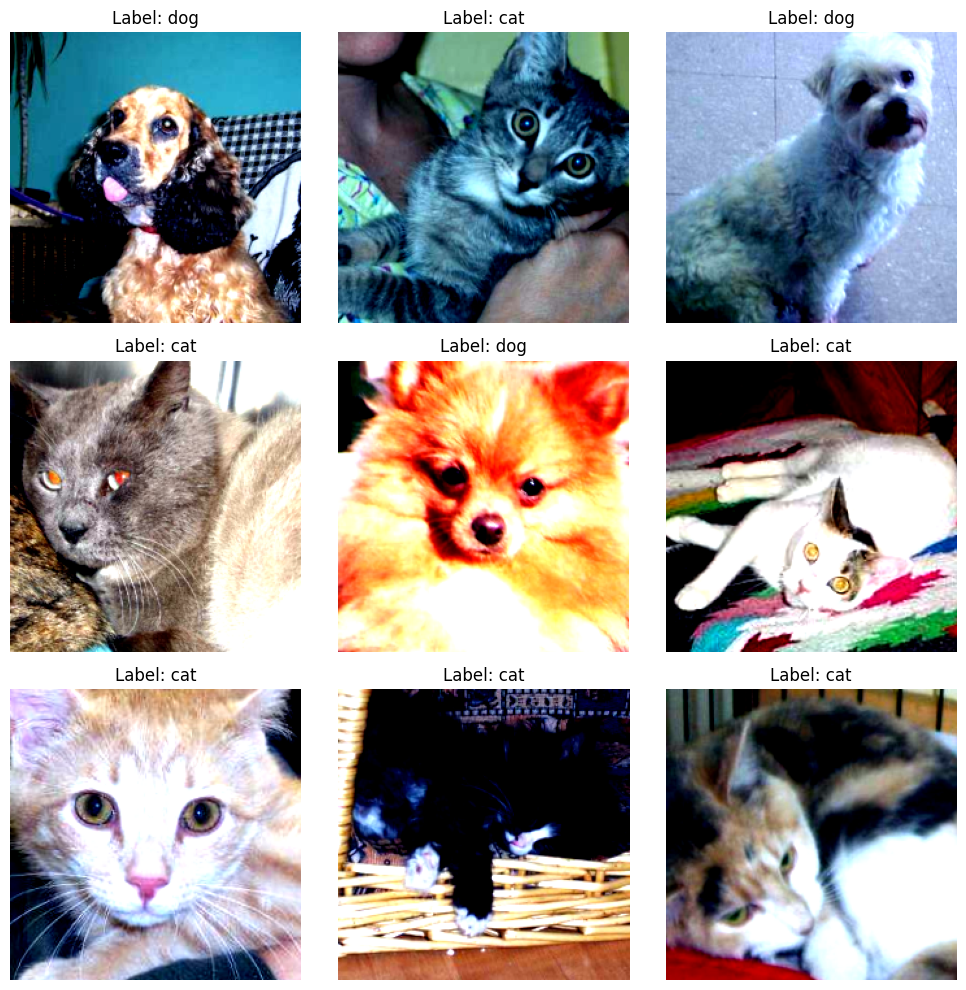

In [12]:
show_multiple_images(trainloader)

# <a id='toc6_'></a>[6. 모델 생성 및 훈련](#toc0_)

### <a id='toc6_1_1_'></a>[6-1. ResNet-34 모델 생성 및 훈련](#toc0_)

In [13]:
# ResNet-34 모델 생성 (Dogs vs Cats: 224x224, 2 classes)
resnet34 = build_resnet(input_shape=(3, 224, 224), num_classes=2, is_plain=False, is_50=False)
print(resnet34)

Building ResNet34 for input shape (3, 224, 224) with 2 classes
Total parameters: 21,285,698
Trainable parameters: 21,285,698
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [14]:
# ResNet-34 훈련
history_resnet34 = train(
    model=resnet34,
    train_loader=trainloader,
    val_loader=testloader,
    epochs=EPOCH,
    initial_lr=LR,
    device='cuda',
    milestones=MILESTONE
)

Training on device: cuda

Training Configuration:
  Epochs: 15
  Initial LR: 0.05
  Momentum: 0.9
  Weight Decay: 0.0001
  LR Milestones: [4, 8, 12]
  Mixed Precision: True



/tmp/ipykernel_5679/1119750308.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipykernel_5679/1119750308.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch [100/625] | Loss: 1.0116 | Acc: 50.03%
  Batch [200/625] | Loss: 0.7010 | Acc: 51.66%
  Batch [300/625] | Loss: 0.7086 | Acc: 53.05%
  Batch [400/625] | Loss: 0.6710 | Acc: 53.91%
  Batch [500/625] | Loss: 0.6484 | Acc: 54.69%
  Batch [600/625] | Loss: 0.5983 | Acc: 55.65%


/tmp/ipykernel_5679/1119750308.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [1/15] - Time: 40.07s - LR: 0.050000
  Train Loss: 0.7915 | Train Acc: 55.97%
  Val Loss: 0.7346 | Val Acc: 57.52%
  Best Val Acc: 57.52% (Epoch 1)
  Batch [100/625] | Loss: 0.6723 | Acc: 61.31%
  Batch [200/625] | Loss: 0.6187 | Acc: 62.81%
  Batch [300/625] | Loss: 0.8184 | Acc: 62.84%
  Batch [400/625] | Loss: 0.6021 | Acc: 63.15%
  Batch [500/625] | Loss: 0.7699 | Acc: 63.82%
  Batch [600/625] | Loss: 0.6323 | Acc: 64.11%

Epoch [2/15] - Time: 39.51s - LR: 0.050000
  Train Loss: 0.6363 | Train Acc: 64.22%
  Val Loss: 0.6007 | Val Acc: 69.08%
  Best Val Acc: 69.08% (Epoch 2)
  Batch [100/625] | Loss: 0.5506 | Acc: 66.81%
  Batch [200/625] | Loss: 0.5945 | Acc: 67.17%
  Batch [300/625] | Loss: 0.6675 | Acc: 67.36%
  Batch [400/625] | Loss: 0.6175 | Acc: 67.41%
  Batch [500/625] | Loss: 0.6152 | Acc: 67.84%
  Batch [600/625] | Loss: 0.5376 | Acc: 68.11%

Epoch [3/15] - Time: 38.51s - LR: 0.050000
  Train Loss: 0.5958 | Train Acc: 68.22%
  Val Loss: 0.5689 | Val Acc: 71.30%
  Be

### <a id='toc6_1_2_'></a>[6-2. ResNet-50 모델 생성 및 훈련](#toc0_)

In [15]:
# ResNet-50 모델 생성 (Dogs vs Cats: 224x224, 2 classes)
resnet50 = build_resnet(input_shape=(3, 224, 224), num_classes=2, is_plain=False, is_50=True)
print(resnet50)

Building ResNet50 for input shape (3, 224, 224) with 2 classes
Total parameters: 23,512,130
Trainable parameters: 23,512,130
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [16]:
# ResNet-50 훈련
history_resnet50 = train(
    model=resnet50,
    train_loader=trainloader,
    val_loader=testloader,
    epochs=EPOCH,
    initial_lr=LR,
    device='cuda',
    milestones=MILESTONE
)

Training on device: cuda

Training Configuration:
  Epochs: 15
  Initial LR: 0.05
  Momentum: 0.9
  Weight Decay: 0.0001
  LR Milestones: [4, 8, 12]
  Mixed Precision: True



/tmp/ipykernel_5679/1119750308.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipykernel_5679/1119750308.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch [100/625] | Loss: 0.7366 | Acc: 51.00%
  Batch [200/625] | Loss: 0.8792 | Acc: 50.30%
  Batch [300/625] | Loss: 0.8920 | Acc: 50.56%
  Batch [400/625] | Loss: 0.7171 | Acc: 50.70%
  Batch [500/625] | Loss: 0.7961 | Acc: 50.66%
  Batch [600/625] | Loss: 0.7201 | Acc: 50.44%


/tmp/ipykernel_5679/1119750308.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [1/15] - Time: 60.72s - LR: 0.050000
  Train Loss: 0.9785 | Train Acc: 50.51%
  Val Loss: 0.7077 | Val Acc: 52.18%
  Best Val Acc: 52.18% (Epoch 1)
  Batch [100/625] | Loss: 0.7115 | Acc: 53.31%
  Batch [200/625] | Loss: 0.6752 | Acc: 54.14%
  Batch [300/625] | Loss: 0.6763 | Acc: 55.15%
  Batch [400/625] | Loss: 0.6774 | Acc: 56.09%
  Batch [500/625] | Loss: 0.6810 | Acc: 56.94%
  Batch [600/625] | Loss: 0.6691 | Acc: 57.51%

Epoch [2/15] - Time: 60.79s - LR: 0.050000
  Train Loss: 0.6780 | Train Acc: 57.45%
  Val Loss: 0.6630 | Val Acc: 60.16%
  Best Val Acc: 60.16% (Epoch 2)
  Batch [100/625] | Loss: 0.7771 | Acc: 61.16%
  Batch [200/625] | Loss: 0.6626 | Acc: 62.44%
  Batch [300/625] | Loss: 0.6900 | Acc: 61.55%
  Batch [400/625] | Loss: 0.7433 | Acc: 61.94%
  Batch [500/625] | Loss: 0.7287 | Acc: 62.19%
  Batch [600/625] | Loss: 0.5267 | Acc: 62.68%

Epoch [3/15] - Time: 60.94s - LR: 0.050000
  Train Loss: 0.6485 | Train Acc: 62.91%
  Val Loss: 0.6076 | Val Acc: 66.66%
  Be

### <a id='toc6_1_3_'></a>[6-3. Plain-34 모델 생성 및 훈련](#toc0_)

In [17]:
# Plain-34 모델 생성 (Dogs vs Cats: 224x224, 2 classes)
plain34 = build_resnet(input_shape=(3, 224, 224), num_classes=2, is_plain=True, is_50=False)
print(plain34)

Building ResNet34 for input shape (3, 224, 224) with 2 classes
Total parameters: 21,285,698
Trainable parameters: 21,285,698
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [18]:
# Plain-34 훈련
history_plain34 = train(
    model=plain34,
    train_loader=trainloader,
    val_loader=testloader,
    epochs=EPOCH,
    initial_lr=LR,
    device='cuda',
    milestones=MILESTONE
)

Training on device: cuda

Training Configuration:
  Epochs: 15
  Initial LR: 0.05
  Momentum: 0.9
  Weight Decay: 0.0001
  LR Milestones: [4, 8, 12]
  Mixed Precision: True



/tmp/ipykernel_5679/1119750308.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipykernel_5679/1119750308.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch [100/625] | Loss: 0.6847 | Acc: 50.38%
  Batch [200/625] | Loss: 0.6649 | Acc: 50.22%
  Batch [300/625] | Loss: 0.6879 | Acc: 51.05%
  Batch [400/625] | Loss: 0.7461 | Acc: 51.12%
  Batch [500/625] | Loss: 0.6606 | Acc: 51.47%
  Batch [600/625] | Loss: 0.6736 | Acc: 51.76%


/tmp/ipykernel_5679/1119750308.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [1/15] - Time: 36.76s - LR: 0.050000
  Train Loss: 0.7083 | Train Acc: 51.80%
  Val Loss: 0.6863 | Val Acc: 50.56%
  Best Val Acc: 50.56% (Epoch 1)
  Batch [100/625] | Loss: 0.6781 | Acc: 53.00%
  Batch [200/625] | Loss: 0.7068 | Acc: 52.14%
  Batch [300/625] | Loss: 0.7303 | Acc: 52.45%
  Batch [400/625] | Loss: 0.7094 | Acc: 52.58%
  Batch [500/625] | Loss: 0.6810 | Acc: 52.59%
  Batch [600/625] | Loss: 0.6625 | Acc: 52.86%

Epoch [2/15] - Time: 36.54s - LR: 0.050000
  Train Loss: 0.6900 | Train Acc: 53.01%
  Val Loss: 0.6958 | Val Acc: 52.74%
  Best Val Acc: 52.74% (Epoch 2)
  Batch [100/625] | Loss: 0.6793 | Acc: 52.75%
  Batch [200/625] | Loss: 0.6927 | Acc: 51.81%
  Batch [300/625] | Loss: 0.6349 | Acc: 51.88%
  Batch [400/625] | Loss: 0.6537 | Acc: 52.26%
  Batch [500/625] | Loss: 0.6822 | Acc: 52.34%
  Batch [600/625] | Loss: 0.7138 | Acc: 52.16%

Epoch [3/15] - Time: 36.34s - LR: 0.050000
  Train Loss: 0.6899 | Train Acc: 52.20%
  Val Loss: 0.6803 | Val Acc: 54.06%
  Be

### <a id='toc6_1_4_'></a>[6-4. Plain-50 모델 생성 및 훈련](#toc0_)

In [19]:
# Plain-50 모델 생성 (Dogs vs Cats: 224x224, 2 classes)
plain50 = build_resnet(input_shape=(3, 224, 224), num_classes=2, is_plain=True, is_50=True)
print(plain50)

Building ResNet50 for input shape (3, 224, 224) with 2 classes
Total parameters: 23,512,130
Trainable parameters: 23,512,130
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [20]:
# Plain-50 훈련
history_plain50 = train(
    model=plain50,
    train_loader=trainloader,
    val_loader=testloader,
    epochs=EPOCH,
    initial_lr=LR,
    device='cuda',
    milestones=MILESTONE
)

Training on device: cuda

Training Configuration:
  Epochs: 15
  Initial LR: 0.05
  Momentum: 0.9
  Weight Decay: 0.0001
  LR Milestones: [4, 8, 12]
  Mixed Precision: True



/tmp/ipykernel_5679/1119750308.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipykernel_5679/1119750308.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch [100/625] | Loss: 0.7596 | Acc: 50.72%
  Batch [200/625] | Loss: 0.6949 | Acc: 50.47%
  Batch [300/625] | Loss: 0.6888 | Acc: 50.77%
  Batch [400/625] | Loss: 0.7085 | Acc: 50.41%
  Batch [500/625] | Loss: 0.6948 | Acc: 50.21%
  Batch [600/625] | Loss: 0.6967 | Acc: 50.14%


/tmp/ipykernel_5679/1119750308.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [1/15] - Time: 49.14s - LR: 0.050000
  Train Loss: 0.7577 | Train Acc: 50.24%
  Val Loss: 0.7338 | Val Acc: 50.56%
  Best Val Acc: 50.56% (Epoch 1)
  Batch [100/625] | Loss: 0.6948 | Acc: 51.53%
  Batch [200/625] | Loss: 0.6904 | Acc: 51.48%
  Batch [300/625] | Loss: 0.7076 | Acc: 51.28%
  Batch [400/625] | Loss: 0.6894 | Acc: 51.12%
  Batch [500/625] | Loss: 0.7096 | Acc: 50.85%
  Batch [600/625] | Loss: 0.7066 | Acc: 50.82%

Epoch [2/15] - Time: 49.35s - LR: 0.050000
  Train Loss: 0.6939 | Train Acc: 50.85%
  Val Loss: 0.7244 | Val Acc: 50.56%
  Best Val Acc: 50.56% (Epoch 1)
  Batch [100/625] | Loss: 0.6747 | Acc: 51.22%
  Batch [200/625] | Loss: 0.6706 | Acc: 51.55%
  Batch [300/625] | Loss: 0.6986 | Acc: 51.94%
  Batch [400/625] | Loss: 0.6798 | Acc: 51.82%
  Batch [500/625] | Loss: 0.7146 | Acc: 51.77%
  Batch [600/625] | Loss: 0.6525 | Acc: 51.80%

Epoch [3/15] - Time: 49.29s - LR: 0.050000
  Train Loss: 0.6928 | Train Acc: 51.91%
  Val Loss: 0.7013 | Val Acc: 50.90%
  Be

# <a id='toc7_'></a>[7. 시각화 비교](#toc0_)

### <a id='toc7_1_1_'></a>[7-1. Plain34, Plain50 loss graph](#toc0_)

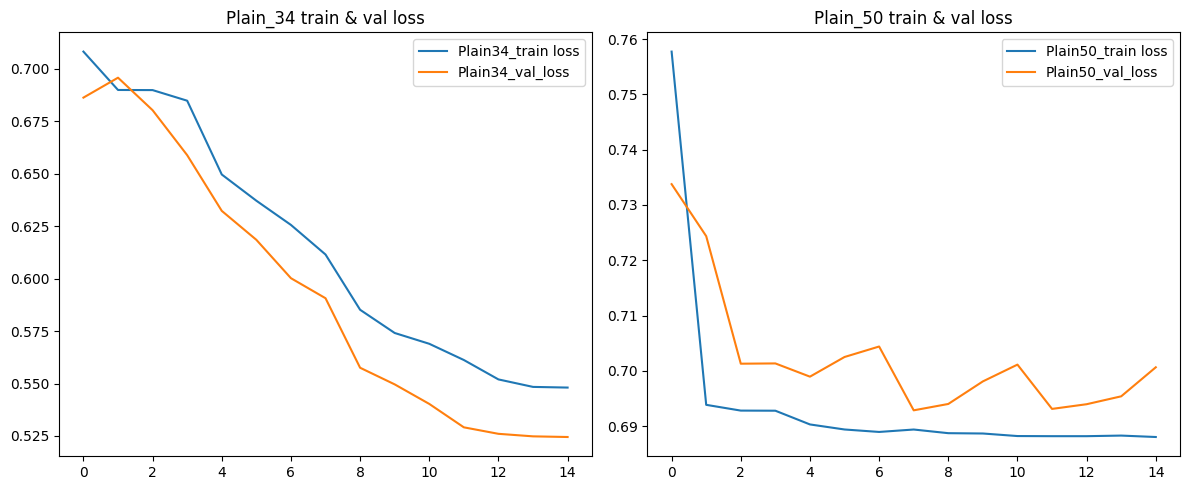

In [21]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_plain34['train_loss'], label="Plain34_train loss")
ax1.plot(history_plain34['val_loss'], label="Plain34_val_loss")
ax1.set_title("Plain_34 train & val loss")
ax1.legend()


ax2.plot(history_plain50['train_loss'], label="Plain50_train loss")
ax2.plot(history_plain50['val_loss'], label="Plain50_val_loss")
ax2.set_title("Plain_50 train & val loss")
ax2.legend()

plt.tight_layout()
plt.show()

### <a id='toc7_1_2_'></a>[7-2. ResNet34, ResNet50 loss graph](#toc0_)

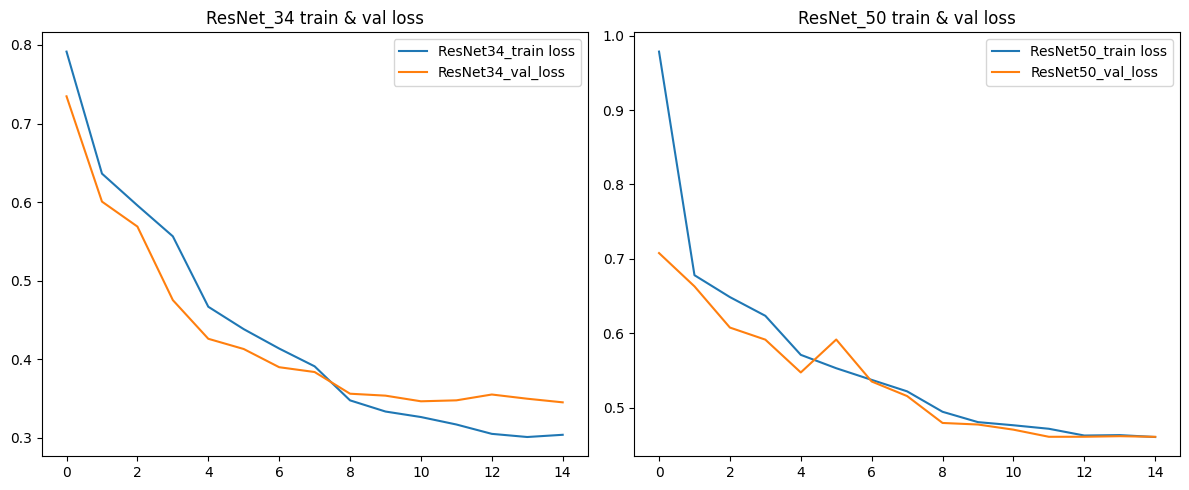

In [22]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_resnet34['train_loss'], label="ResNet34_train loss")
ax1.plot(history_resnet34['val_loss'], label="ResNet34_val_loss")
ax1.set_title("ResNet_34 train & val loss")
ax1.legend()


ax2.plot(history_resnet50['train_loss'], label="ResNet50_train loss")
ax2.plot(history_resnet50['val_loss'], label="ResNet50_val_loss")
ax2.set_title("ResNet_50 train & val loss")
ax2.legend()

plt.tight_layout()
plt.show()

### <a id='toc7_1_3_'></a>[7-3. Plain34 vs Plain50](#toc0_)

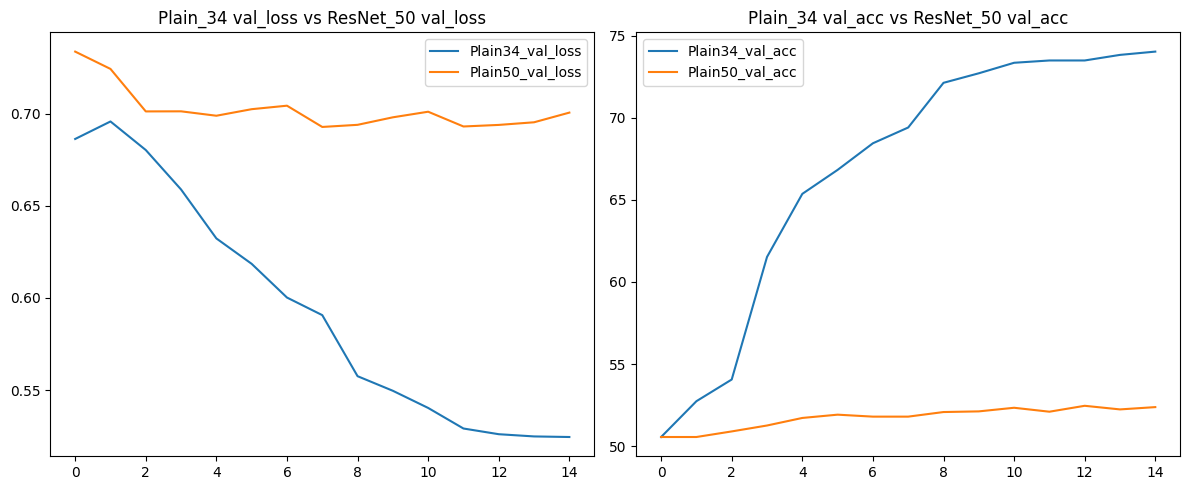

In [23]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_plain34['val_loss'], label="Plain34_val_loss")
ax1.plot(history_plain50['val_loss'], label="Plain50_val_loss")
ax1.set_title("Plain_34 val_loss vs ResNet_50 val_loss")
ax1.legend()

ax2.plot(history_plain34['val_acc'], label="Plain34_val_acc")
ax2.plot(history_plain50['val_acc'], label="Plain50_val_acc")
ax2.set_title("Plain_34 val_acc vs ResNet_50 val_acc")
ax2.legend()

plt.tight_layout()
plt.show()

### <a id='toc7_1_4_'></a>[7-4. ResNet34 vs ResNet50](#toc0_)

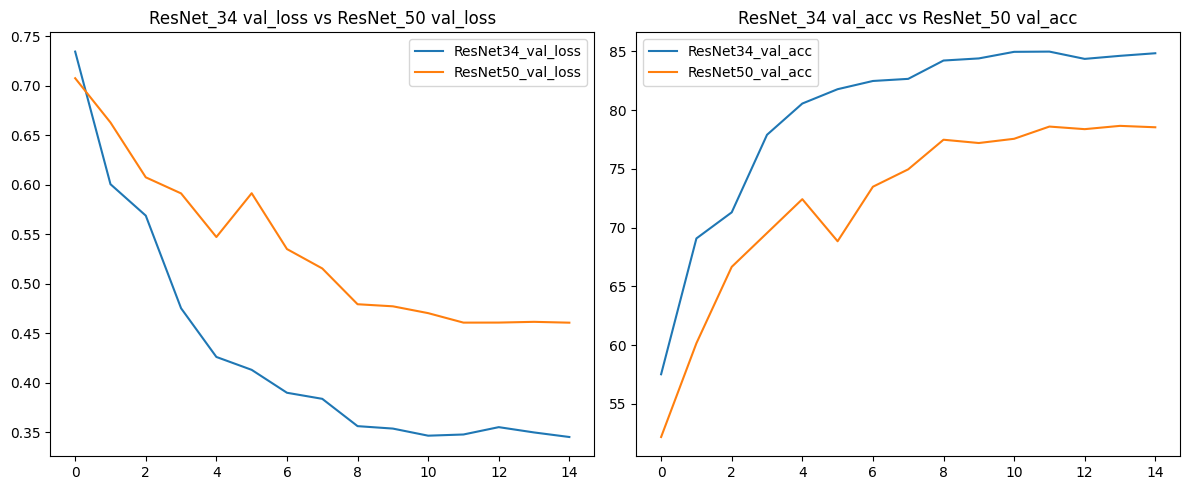

In [24]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_resnet34['val_loss'], label="ResNet34_val_loss")
ax1.plot(history_resnet50['val_loss'], label="ResNet50_val_loss")
ax1.set_title("ResNet_34 val_loss vs ResNet_50 val_loss")
ax1.legend()

ax2.plot(history_resnet34['val_acc'], label="ResNet34_val_acc")
ax2.plot(history_resnet50['val_acc'], label="ResNet50_val_acc")
ax2.set_title("ResNet_34 val_acc vs ResNet_50 val_acc")
ax2.legend()

plt.tight_layout()
plt.show()

### <a id='toc7_1_5_'></a>[7-5. Plain_val_loss vs ResNet_val_loss](#toc0_)

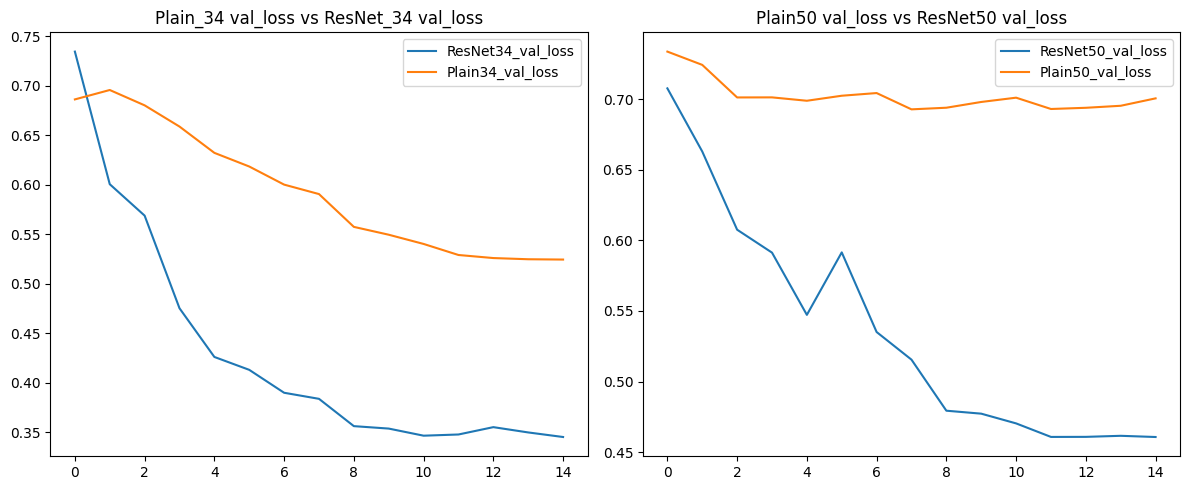

In [25]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_resnet34['val_loss'], label="ResNet34_val_loss")
ax1.plot(history_plain34['val_loss'], label="Plain34_val_loss")
ax1.set_title("Plain_34 val_loss vs ResNet_34 val_loss")
ax1.legend()

ax2.plot(history_resnet50['val_loss'], label="ResNet50_val_loss")
ax2.plot(history_plain50['val_loss'], label="Plain50_val_loss")
ax2.set_title("Plain50 val_loss vs ResNet50 val_loss")
ax2.legend()

plt.tight_layout()
plt.show()

### <a id='toc7_1_6_'></a>[7-6. Plain_val_acc vs ResNet_val_acc](#toc0_)

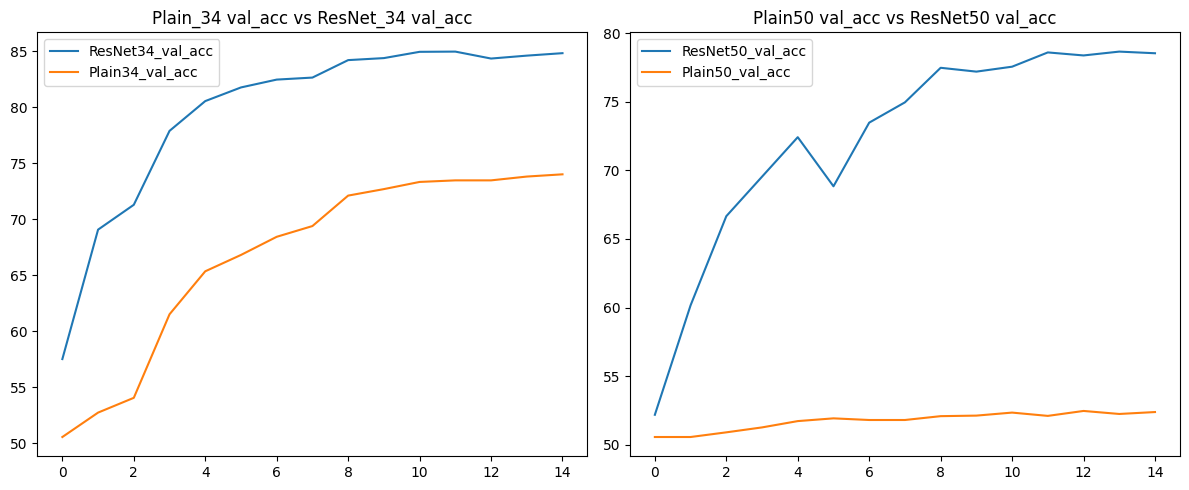

In [26]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_resnet34['val_acc'], label="ResNet34_val_acc")
ax1.plot(history_plain34['val_acc'], label="Plain34_val_acc")
ax1.set_title("Plain_34 val_acc vs ResNet_34 val_acc")
ax1.legend()

ax2.plot(history_resnet50['val_acc'], label="ResNet50_val_acc")
ax2.plot(history_plain50['val_acc'], label="Plain50_val_acc")
ax2.set_title("Plain50 val_acc vs ResNet50 val_acc")
ax2.legend()

plt.tight_layout()
plt.show()

# 8. 소감
- 힘들다... LMS나 Colab에서 돌리면 이렇게 노트북이 꺼지는 현상은 없지는 않을까? 싶다..
- 저녁이면 충분히 다 할 수 있는 태스크인데, 새벽 3시, 4시까지 이걸 하고있다.